#**DATA PREPROCESSING**

- **Data pre-processing** is one of the steps of preparing data for machine learning algorithms. To do this, let's see how to create custom layers using the library, the Keras API, and how to read multiple files, prepare them, process them and train the algorithms.

- 1-Let's import **the libraries**

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import os

In [2]:
data=pd.read_csv('/content/train.csv')

In [3]:
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


- **The csv files are very slow**, we will use different files to handle large volumes of data

- Let's use **parquet files**

In [4]:
data.to_parquet('my_data.parquet')

In [5]:
data_parquet=pd.read_parquet('/content/my_data.parquet')

In [6]:
data_parquet.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [7]:
data_parquet.shape

(1460, 81)

-  1-Viewing **Null Data**

<Axes: >

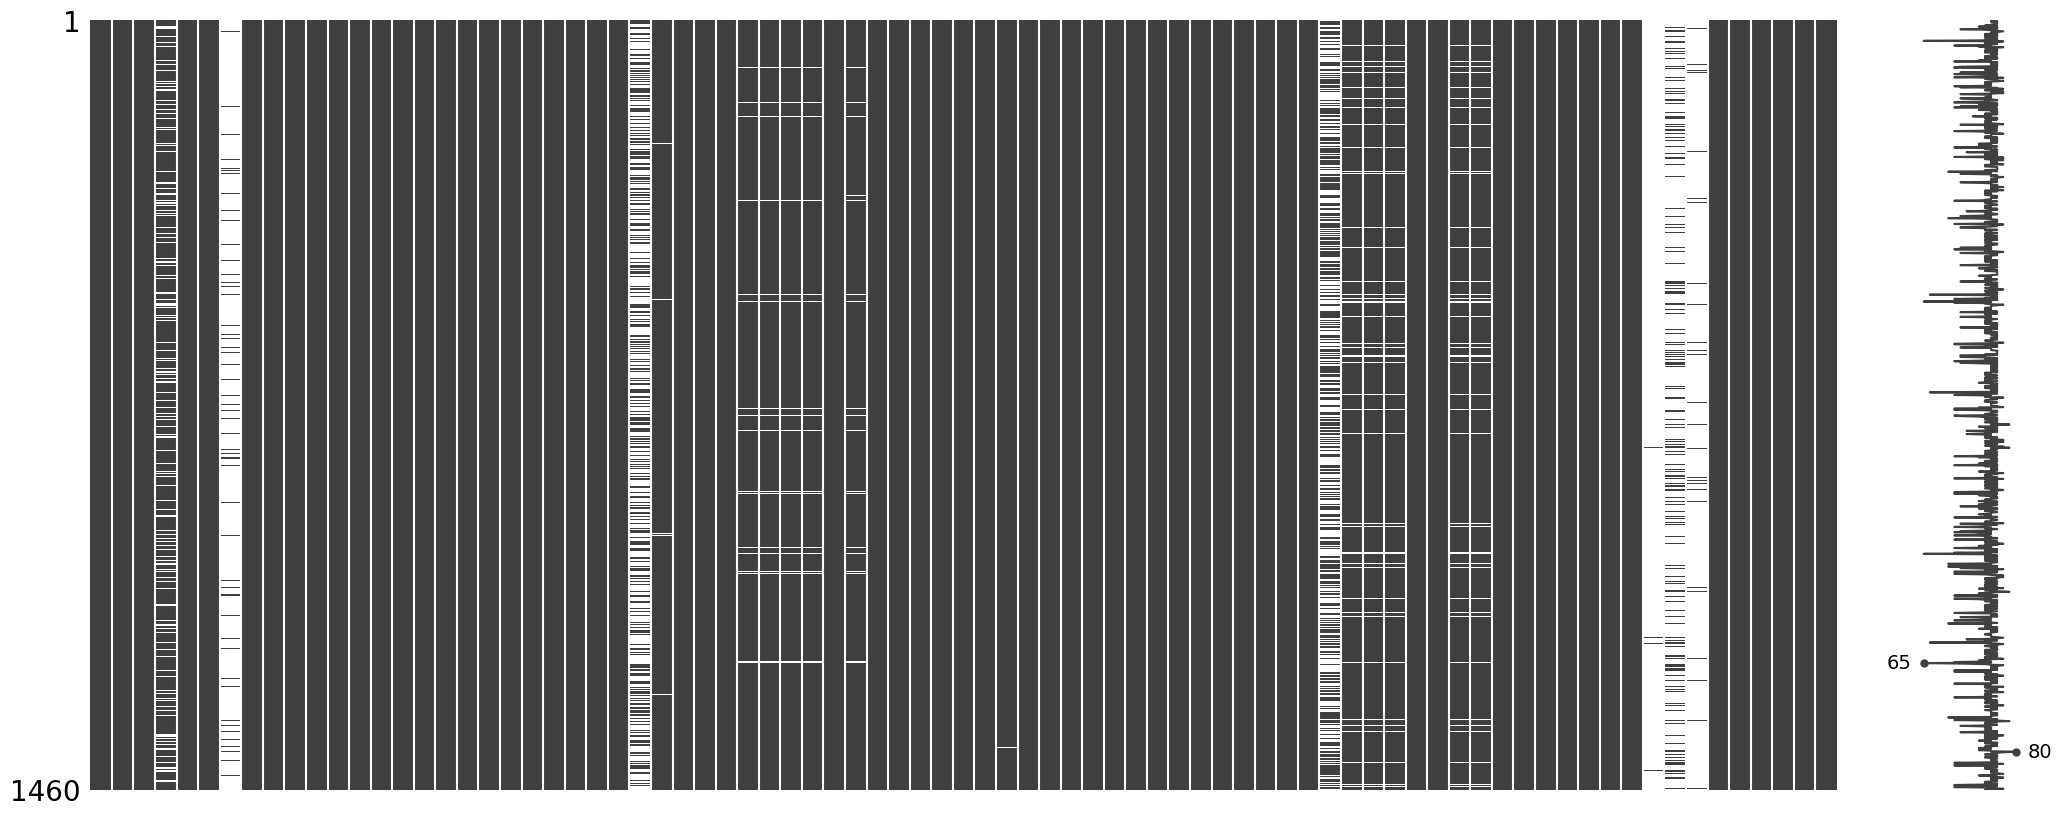

In [8]:
msno.matrix(data_parquet)

- We can see that there are a lot of columns with null data

In [9]:
data_parquet.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

- What is null data?

- **Null data**, is data that does not represent the primitive data types in **programming languages**. In a tabular structure, there aren't even fields that can't be empty. when these fields don't have values, they can be represented with **values like NaN**

- **Many of the causes** of null values can be because of the privacy of customers or people who do not want to reveal their information. Or maybe it's also because I forgot to fill out a form... There are many reasons to think about this

- How to deal with **null data?**

- Dealing with null data can be challenging. However, there are some techniques that can be used to deal with it

- **1**-Delete **null data** (rows or columns)

- **2**-Use an imputation strategy for null values
  **(median,mean)**

- **3**-Create a predictive model to predict possible   missing values

- Of these strategies that have been defined, the most acceptable is to use an imputation strategy since there will be no loss of information if we eliminate data. Since this data can be useful for the model to learn patterns and have efficient training.

- Similarly, we can **train a model without these columns with null values**.. and predict possible values for these columns that have null data with the trained model, but this can be complex, even more so if we have a lot of null data in the dataset

- Let's create a class to handle the imputation of the null data.. using an imputation strategy based on the median and frequency of the columns.

In [10]:
class InputDataCategory(BaseEstimator,TransformerMixin):
  def __init__(self,columns):
    self.columns=columns

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    imputer=SimpleImputer(
        strategy = 'most_frequent'
    )
    X=imputer.fit_transform(X[self.columns])

    return X

class InputDataNumeric(BaseEstimator,TransformerMixin):
  def __init__(self,columns):
    self.columns=columns

  def fit(self,X,y=None):
    return self

  def transform(self,X,y=None):
    imputer=SimpleImputer(
        strategy='median'
    )

    X=imputer.fit_transform(
        X[self.columns]
    )

    return X

In [11]:
dataNum=data.select_dtypes(include=['number'])
dataCat=data.select_dtypes(include=['object'])

In [12]:
pipeLineCat = Pipeline([
    ('ImputerCat', InputDataCategory(columns=list(dataCat))),
])

pipeLineNum = Pipeline([
    ('ImputerNUm', InputDataNumeric(columns=list(dataNum)))
])

pipeLineFull = ColumnTransformer([
    ('pipenum', pipeLineNum, list(dataNum)),
    ('pipecat', pipeLineCat, list(dataCat))
])

data_merge = pd.merge(dataNum, dataCat, left_index=True, right_index=True)

data_transform = pipeLineFull.fit_transform(data_merge)

data_full = pd.DataFrame(data_transform, columns=data_merge.columns, index=data_merge.index)


- Now we have the data cleaned up ...

In [13]:
data_full

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,Detchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Abnorml
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,...,Attchd,RFn,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
1456,1457.0,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
1457,1458.0,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,...,Attchd,RFn,TA,TA,Y,Gd,GdPrv,Shed,WD,Normal
1458,1459.0,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal


- In short, what we've done so far is we've separated the data into 2 types of categories, numeric and strings, we've created imputation pipelines to work individually for each category


- In the end, we put it all together into a single data set.

In [14]:
for col in dataNum.columns.tolist():
  data_full[col]=data_full[col].astype(np.float64)

-  How to deal with **categorical variables?** when we have a large number of categorical variables it is not advisable to use the **OHE reference encoding**, this is because it can cause a substantial increase in the dimension in the data... A good alternative to use is to use **frequency coding.**

- Frequency encoding **works** by **replacing the category**  with the number of repetitions that appear.

In [15]:
def EncodingFrequency(df):
  for col in dataCat.columns.tolist():
    mappings=df[col].value_counts()
    df[col]=df[col].map(mappings)
  return df

In [16]:
data_full=EncodingFrequency(data_full)

In [17]:
data_full

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,951,422,1392,1407,1340,1456,1336,1455,1267,1198
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,951,422,1392,1407,1340,1456,1336,1455,1267,1198
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,951,422,1392,1407,1340,1456,1336,1455,1267,1198
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,387,686,1392,1407,1340,1456,1336,1455,1267,101
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,951,422,1392,1407,1340,1456,1336,1455,1267,1198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,...,951,422,1392,1407,1340,1456,1336,1455,1267,1198
1456,1457.0,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,...,951,686,1392,1407,1340,1456,1336,1455,1267,1198
1457,1458.0,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,...,951,422,1392,1407,1340,1456,59,1455,1267,1198
1458,1459.0,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,...,951,686,1392,1407,1340,1456,1336,1455,1267,1198


- We can see that the categorical variables have been replaced with their number of **specific counts**

-  What we've done so far ?.. Well, we have imputed the **missing data**. and coded the categorical variables **using frequency coding**

- We know that **most optimization algorithms work** best when data is scrambled and normalized. To do this, we're going to create a function that will split the dataset into several files under Training and Test.

In [18]:
target=data_full['SalePrice']
data_full.drop(
    columns=['SalePrice'],
    axis=1,
    inplace=True
)

data_full['SalePrice']=target

In [19]:
def Train_test_split(df,y_target):
  try:
    y_target=str(y_target)
    if y_target in df.columns:
      X=df.drop(columns=[y_target],axis=1)
      y=df[y_target]
      X_train_all,X_test,y_train_all,y_test=train_test_split(
          X.loc[:,X.columns[1:]],
          y.values.reshape(-1,1),
          random_state=24
      )
      X_train,X_valid,y_train,y_valid=train_test_split(
          X_train_all,y_train_all,
          random_state=24
      )
      return X_train,X_test,y_train,y_test,X_valid,y_valid
  except (TypeError) as e:
   raise type(e)(f'[ERROR]')

In [20]:
X_train,X_test,y_train,y_test,X_valid,y_valid=Train_test_split(data_full,'SalePrice')

- Now, let's take the **mean** and **standard deviation** for each feature in the **dataset**

In [21]:
std=StandardScaler()
std.fit(X_train)
mean_=std.mean_
std_mean=std.scale_

- Now let's create a function that will split different training and test **datasets into multiple files**

In [22]:
def save_multiple_files(data, prefix_name, header=None, n_parts=10):
    dataset_file = os.path.join('dataset', 'housePrices')
    os.makedirs(dataset_file, exist_ok=True)
    format_path = os.path.join(dataset_file, 'my_{}_{:02d}.csv')
    file_paths = []
    m = len(data)

    for file_idx, array_index in enumerate(np.array_split(np.arange(m), n_parts)):
        format_path_current = format_path.format(prefix_name, file_idx)
        file_paths.append(format_path_current)
        with open(format_path_current, mode='wt', encoding='utf-8') as f:
            if header is not None:
                f.write(header)
                f.write('\n')
            for row in array_index:
                f.write(",".join(repr(value) for value in data[row]))
                f.write('\n')

    return file_paths


In [23]:
header=",".join(data_full.columns.tolist())

In [24]:
train_set=np.c_[X_train,y_train]
test_set=np.c_[X_test,y_test]
valid_set=np.c_[X_valid,y_valid]

In [25]:
filePathTrain=save_multiple_files(train_set,'train',header=header,n_parts=10)
filePathTest=save_multiple_files(test_set,'test',header=header,n_parts=10)
filePathValid=save_multiple_files(valid_set,'valid',header=header,n_parts=10)

In [26]:
filePathTrain

['dataset/housePrices/my_train_00.csv',
 'dataset/housePrices/my_train_01.csv',
 'dataset/housePrices/my_train_02.csv',
 'dataset/housePrices/my_train_03.csv',
 'dataset/housePrices/my_train_04.csv',
 'dataset/housePrices/my_train_05.csv',
 'dataset/housePrices/my_train_06.csv',
 'dataset/housePrices/my_train_07.csv',
 'dataset/housePrices/my_train_08.csv',
 'dataset/housePrices/my_train_09.csv']

- Training dataset divided **into 10 parts**

- This function r**ead_multiple_files** takes a data set, a prefix for the name of the prefix_name files, an optional **header**, and the desired number of parts into which the dataset should be divided n_parts. It **creates multiple CSV files from the dataset**, splitting it into equal parts and saving each part in a **separate file**.

- **Why do it?** , often the dataset may be too large and not fit in memory.. We can try to use this kind of strategy to deal with these problems.... Not only because of this, but also because it can improve the **training performance of the models.**

- Let's now create a function that will standardize the input data.

In [27]:
@tf.function
def preprocess(lines):
    epsilon = keras.backend.epsilon()
    inputs = X_train.shape[1]
    defaults_inputs = [0.] * inputs + [tf.constant([],dtype=tf.float64)]
    decoder_csv = tf.io.decode_csv(lines, record_defaults=defaults_inputs)
    X = tf.stack(decoder_csv[:-1])
    y = tf.stack(decoder_csv[-1:])
    return (X - mean_) / (std_mean + epsilon), y


- What is this function **doing?**  

- This function takes lines of CSV text as input and
 performs the **following steps**:

- **1-**Calculates the epsilon value to avoid division by zero
  during normalization.

- **2-**Determines the number of input characteristics.
Sets the default values for the CSV fields, including zeros for the traits and zeros for the label.

- **3-**Decodes the CSV rows using the default values.
Stacks the tensors resulting from decoding, separating the X characteristics from the y labels

- **4-** Normalizes the X traits by subtracting the mean mean_ and dividing by the standard deviation std_mean, with the addition of epsilon for stability.

- **5-** Returns a tuple containing the normalized traits X and the labels y.

- Let's now put things together, let's create a function that creates a dataset where you'll have several files and from that dataset, we'll create another one that will **merge different datasets** applying a write function to each file that's being processed, then we'll create a buffer where this data will be **shuffled**,   Then, that same data will be processed and **split into batches**

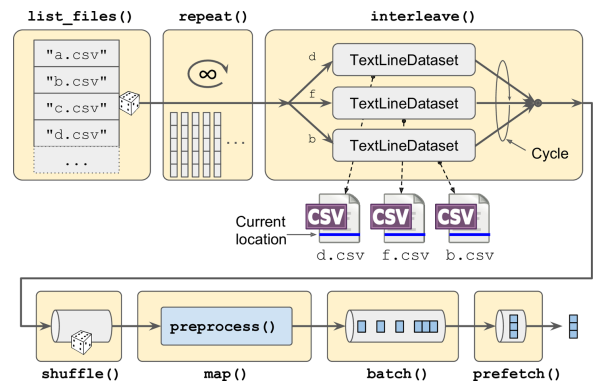

###**Prefetch**

- Finally, we will use a **prefetch**, the prefetch ensures that as a training batch is being processed the other batch will already be processed, this is very useful when we want the preparation of a batch to be **faster**, this also guarantees a substantial increase in the training of the model, while a batch is being passed through the **CPU** and transferred to **GPU**,  before the GPU finishes processing, another batch will already be **prepared.**

- We can also think that prefetching is a way of using **parallelism**

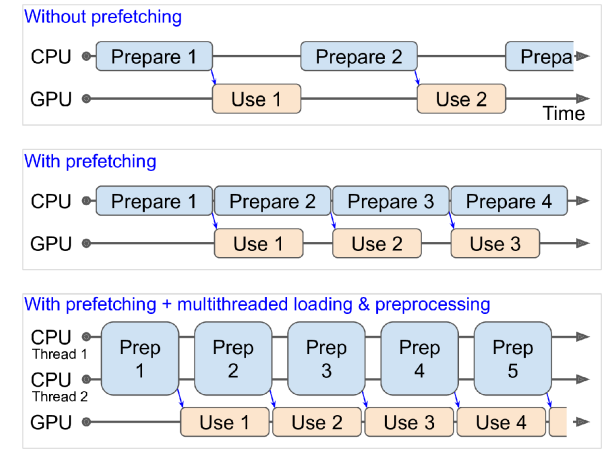

- Now we can create a single function that's going to handle all of this

In [28]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [29]:
dataset_train=csv_reader_dataset(filePathTrain)
dataset_test=csv_reader_dataset(filePathTest)
dataset_valid=csv_reader_dataset(filePathValid)

In [30]:
for item in dataset_train.take(1):
  print(item)

(<tf.Tensor: shape=(32, 79), dtype=float32, numpy=
array([[-0.88345665, -0.22844216, -0.16596697, ...,  0.06055914,
        -2.368538  , -2.0338917 ],
       [-0.18232767, -0.76929444, -0.10575576, ...,  0.06055914,
         0.4072957 ,  0.47828183],
       [ 0.051382  , -0.06202609,  1.6198511 , ...,  0.06055914,
         0.4072957 , -2.090082  ],
       ...,
       [-0.88345665, -0.06202609,  0.07890988, ...,  0.06055914,
         0.4072957 ,  0.47828183],
       [-0.18232767, -0.43646228, -0.22035418, ...,  0.06055914,
         0.4072957 , -2.3171844 ],
       [ 2.855898  , -2.059019  , -0.7821463 , ...,  0.06055914,
         0.4072957 ,  0.47828183]], dtype=float32)>, <tf.Tensor: shape=(32, 1), dtype=float64, numpy=
array([[164990.],
       [ 87000.],
       [185000.],
       [110000.],
       [ 98000.],
       [ 89500.],
       [163000.],
       [147400.],
       [197000.],
       [255900.],
       [319000.],
       [174000.],
       [207500.],
       [377426.],
       [190000.],


Now, let's create the **neural network architecture**

- There are certainly many types of neural network architecture.

- For now, let's use **sequential**

In [31]:
class MyLayer(keras.layers.Layer):
    def __init__(self, n_neurons, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.n_neurons = n_neurons
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=[batch_input_shape[-1], self.n_neurons],
            initializer='he_normal',
            trainable=True
        )
        self.bias = self.add_weight(
            name='bias',
            shape=[self.n_neurons],
            initializer='zeros',
            trainable=True
        )
        super().build(batch_input_shape)

    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.kernel) + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.n_neurons])

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "n_neurons": self.n_neurons,
            'activation': self.activation.__name__
        }


In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)

model=keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[X_train.shape[1]]),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.8),
    MyLayer(30,activation='elu'),
    keras.layers.Dropout(0.7),
    MyLayer(30,activation='elu'),
    keras.layers.Dropout(0.7),
    MyLayer(30,activation='elu'),
    keras.layers.Dropout(0.5),
    MyLayer(30,activation='elu'),
    keras.layers.Dense(1,activation='elu')
])

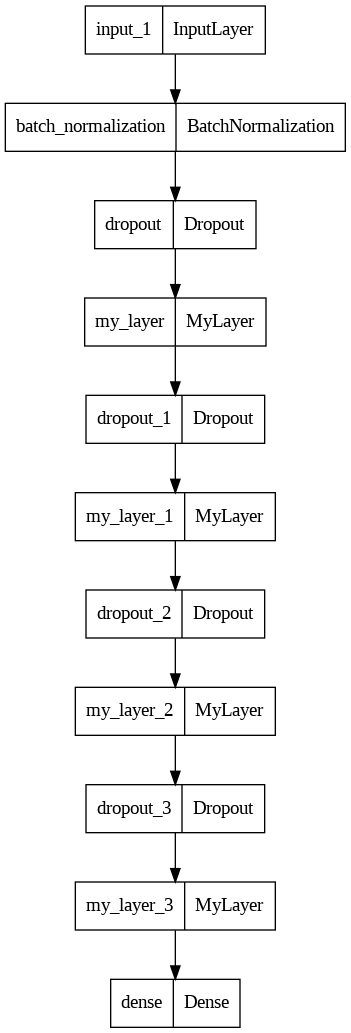

In [33]:
keras.utils.plot_model(model)

- OK, we've got the class created, and the architecture defined, let's now create a custom **training loop**

- First of all, let's **compile the model**

In [34]:
@tf.function
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


In [35]:
model.compile(
    loss=root_mean_squared_error,
    optimizer=keras.optimizers.RMSprop()
)

In [36]:
keras.backend.clear_session()
tf.random.set_seed(42)

optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.mean_absolute_error
def train_model(model, n_epochs):
    train_set=csv_reader_dataset(filePathTrain, repeat=n_epochs)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(tf.square(loss_fn(y_batch,y_pred)))
            loss = tf.add_n([main_loss])
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train_model(model,5)

- Once the model is trained, we can use the test set to make the predictions

In [37]:
model.evaluate(dataset_valid)

9/9 [==============================] - 1s 17ms/step - loss: 190726.0312


190726.03125

- Let's now make the predictions in the test setLet's now make the predictions in the private test

In [38]:
new_set=dataset_test.take(3).map(lambda X,y:X)

In [39]:
model.predict(new_set)

3/3 [==============================] - 1s 30ms/step


array([[-9.99826610e-01],
       [ 2.48026810e+02],
       [ 3.72925568e+01],
       [ 2.34993726e+03],
       [ 1.72442944e+03],
       [ 1.57948103e+01],
       [ 1.22692680e+02],
       [ 1.01369944e+01],
       [ 1.64360828e+03],
       [ 1.08992424e+02],
       [ 5.41577332e+02],
       [ 2.48481293e+01],
       [ 4.10622559e+01],
       [ 2.90590918e+03],
       [ 1.75318359e+03],
       [ 1.50606470e+03],
       [ 7.10083694e+01],
       [ 2.09634180e+03],
       [ 1.36138770e+03],
       [ 1.66569336e+03],
       [ 9.74536743e+02],
       [ 2.47031517e+01],
       [ 1.15489331e+03],
       [ 5.36217346e+01],
       [ 6.04432678e+02],
       [ 1.29810803e+03],
       [ 7.75274582e+01],
       [ 1.52339954e+01],
       [-6.71584964e-01],
       [ 1.98720947e+03],
       [ 4.88155975e+02],
       [ 1.90631123e+01],
       [ 7.67712555e+01],
       [ 2.04094910e+03],
       [ 2.10996189e+01],
       [ 2.28978833e+03],
       [ 1.48271545e+03],
       [-2.72678137e-01],
       [ 1.2

In [40]:
model_history=model.fit(
    dataset_train,
    epochs=128,
    validation_data=(
        dataset_valid
    )
)

Epoch 1/128
26/26 [==============================] - 4s 26ms/step - loss: 195587.0781 - val_loss: 189733.9844
Epoch 2/128
26/26 [==============================] - 1s 27ms/step - loss: 194092.1562 - val_loss: 188320.9219
Epoch 3/128
26/26 [==============================] - 1s 20ms/step - loss: 192367.8594 - val_loss: 186274.3750
Epoch 4/128
26/26 [==============================] - 1s 31ms/step - loss: 190359.0781 - val_loss: 184282.2812
Epoch 5/128
26/26 [==============================] - 1s 27ms/step - loss: 188387.6406 - val_loss: 180676.2969
Epoch 6/128
26/26 [==============================] - 0s 16ms/step - loss: 183810.8125 - val_loss: 176197.6719
Epoch 7/128
26/26 [==============================] - 1s 20ms/step - loss: 178318.1094 - val_loss: 169869.5312
Epoch 8/128
26/26 [==============================] - 1s 30ms/step - loss: 172455.3281 - val_loss: 161509.6250
Epoch 9/128
26/26 [==============================] - 1s 22ms/step - loss: 165583.2344 - val_loss: 151952.3594
Epoch 10/1

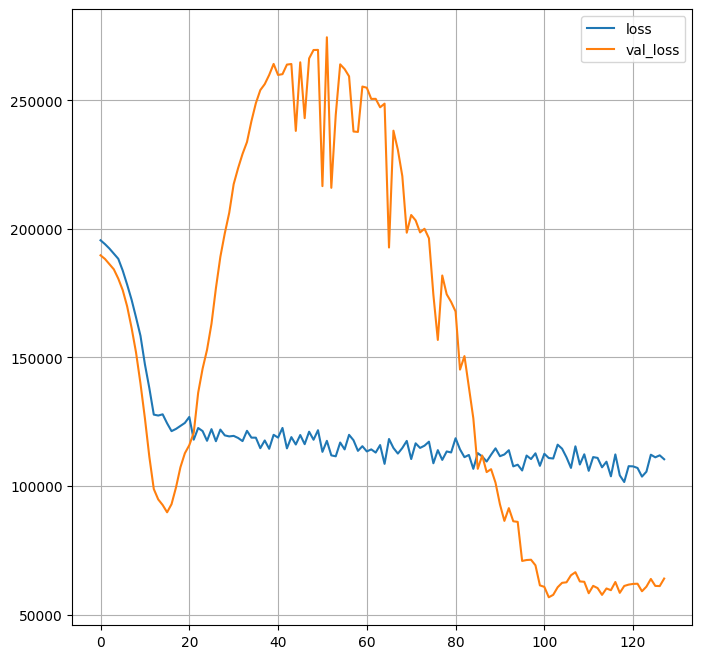

In [41]:
pd.DataFrame(
    model_history.history
).plot(
    figsize=(8,8)
)
plt.grid(True)

# **Conclusion**

- Preprocessing data with both TensorFlow and scikit-learn provides a powerful combination of tools and methods for data manipulation and transformation. While **TensorFlow offers advanced functionalities for efficient data processing and building deep learning models**, scikit-learn provides a wide range of traditional data preprocessing techniques and classical **machine learning** algorithms. With this combination, users can leverage the best of both worlds, applying advanced **preprocessing with TensorFlow and more traditional modeling techniques with scikit-learn**. This enables a flexible and comprehensive **approach** to machine learning solution development that caters to the specific needs of each project.